In [9]:
'''
Program to perform 3D element analysis
Unit: mm
Author: Yitian Shao
Created on 2021.06.02
'''
%matplotlib notebook 

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

meshDensity = 100 # density of vertices of the mesh, large value results in finer grid but larger memory demand

R = 5 # Radius of the sphere
h = 3 # Cutting height of the sphere, Pouch height will be 2(R-h)

In [10]:
def data_cut(x, y, z, ind):
    return x[ind], y[ind], z[ind]

In [11]:
x = np.outer(np.linspace(0, 2*R, meshDensity), np.ones(meshDensity))
y = np.outer(np.linspace(-R, R, meshDensity), np.ones(meshDensity)).T
z = R**2 - (x-R)**2 - (y**2)

# Keep sphere surface
keepInd = (z >= 0)
x, y, z = data_cut(x, y, z, keepInd)
z = np.sqrt(z)

# Cut the sphere
keepInd = (z >= h)
x, y, z = data_cut(x, y, z, keepInd)

<IPython.core.display.Javascript object>


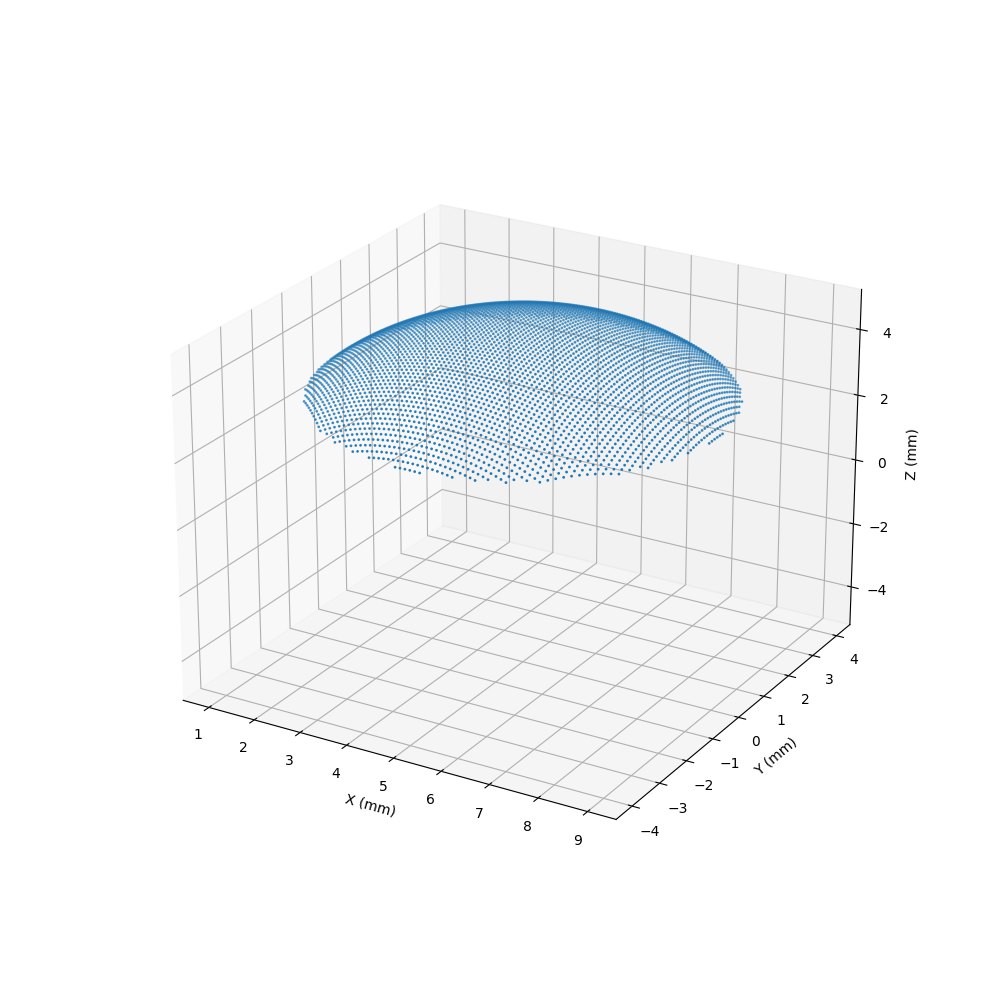

NotImplementedError: Axes3D currently only supports the aspect argument 'auto'. You passed in 'equal'.

In [12]:
fig1 = plt.figure(figsize = (10,10))
ax = fig1.add_subplot(111, projection='3d')
ax.scatter3D(x, y, z, s = 1)
ax.set_xlabel('X (mm)')
ax.set_ylabel('Y (mm)')
ax.set_zlabel('Z (mm)')
ax.set_zlim3d([-R, R])
ax.set_aspect('equal')
plt.show()